### Aplicación de propensity score matching



In [1]:
##Borrar datos del entorno
rm(list=ls())

In [2]:
#Directorio de trabajo
setwd("C:/Users/claud/Documents/GitHub/proyecto_simi")

In [3]:
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse,janitor,MatchIt,cobalt)

Loading required package: pacman



#### 1. Se crea función para realizar el modelo y el matching

In [5]:
propscorematch <- function(var_modelo, link_model, t_test_var) {
  # Función para imprimir texto en negritas y mayúsculas
  bold_text <- function(text) paste0("\033[1m", "=== ", toupper(text), " ===", "\033[0m")
  
  # Modelo GLM
  modelo_glm <- glm(var_modelo, data = datos_colonias, family = link_model)
  
  # Impresión de resultados
  model_type <- ifelse(link_model$link == "logit", "Logit", 
                       ifelse(link_model$link == "probit", "Probit", link_model$link))
  cat(bold_text(paste("Resultados del modelo", model_type, ":")), "\n")
  summary_glm <- summary(modelo_glm)
  print(summary_glm)
  
  # Generación de scores de propensión
  prs_df <- data.frame(pr_score = predict(modelo_glm, type = "response"),
                       simi = datos_colonias$simi)
  
  # MatchIt
  matchit_out <- matchit(var_modelo, data = datos_colonias, method = "nearest", distance = prs_df$pr_score)

  # Impresión de resultados de MatchIt
  cat(bold_text("Resumen de los resultados de MatchIt:"), "\n")
  summary_matchit <- summary(matchit_out)
  print(summary_matchit)
  
  # Datos matcheados
  datos_matcheados <- match.data(matchit_out)
  
  # Imprimiendo resultados
  cat(bold_text("Número de manzanas matcheadas:"), nrow(datos_matcheados), "\n")
  cat(bold_text("Número de manzanas matcheadas sin considerar Lomas de San Carlos:"), 
      nrow(datos_matcheados[datos_matcheados$simi == 0, ]), "\n")
  
    # Plot MatchIt
  matchit_plot <- plot(summary_matchit)
  # Definición de grupos para el t-test
  group_0 <- "Grupo de control (simi = 0)"
  group_1 <- "Grupo de tratamiento (simi = 1)"
  
  # Impresión del encabezado de los resultados del t-test
  cat(bold_text("Average Treatment Effect among the Treated (ATT):"), "\n")
  cat(bold_text("Grupo 0:"), group_0, "\n")
  cat(bold_text("Grupo 1:"), group_1, "\n")
  
  # T-test
  cat(bold_text("Resultados de la prueba t:"), "\n")
  
  
  formula_t_test <- as.formula(paste(t_test_var, "~ simi"))
  t_test_result <- t.test(formula_t_test, data = datos_matcheados)
  print(t_test_result)
  
  # Calcular ATT
  att <- mean(datos_matcheados[datos_matcheados$simi == 1, ][[t_test_var]]) -
              mean(datos_matcheados[datos_matcheados$simi == 0, ][[t_test_var]])
  

  
  # Calcular ATE
  mean_treated <- mean(datos_colonias[datos_colonias$simi == 1, ][[t_test_var]])
  mean_control <- mean(datos_colonias[datos_colonias$simi == 0, ][[t_test_var]])
  ate <- mean_treated - mean_control
  # Print
  cat(bold_text("Medias del Grupo Tratamiento y Control para el Cálculo del ATE:"), "\n")
  cat(bold_text("Para esto, se utilizan todos los datos, no solo los matcheados."), "\n")
  
  cat("Media del Grupo Tratamiento (simi = 1):", mean_treated, "\n")
  cat("Media del Grupo Control (simi = 0):", mean_control, "\n\n\n")
  

  cat(bold_text("Average Treatment Effect on the Treated (ATT):"), "\n")
  cat("ATT =", att, "\n")
  cat(bold_text("Average Treatment Effect (ATE):"), "\n")
  cat("ATE =", ate, "\n")
}


#### 2. Se cargan los datos tanto de la colonia Simi como de las colonias "similares" y 
Se crea una dummy para identificar a qué grupo pertenece cada observación. Estos datos son a nivel manzana y corresponden a 67 colonias, considerando la colonia Lomas de San Carlos. La fuente de información es el Censo de Población y Vivienda 2020.

In [6]:
#Cargar datos
datos_colonias<-openxlsx::read.xlsx("G:/Mi unidad/proyecto_simi/indicadores_mza_col.xlsx",sheet=2)%>%
#Crea dummy para identificar si la manzana pertenece a colonia simi o no
mutate(simi=case_when(colonia=="Lomas de San Carlos" ~ 1,
                        TRUE ~ 0))
str(datos_colonias)

'data.frame':	2904 obs. of  39 variables:
 $ cvegeo         : chr  "0900500010258020" "0900500010258035" "0900500010258009" "0900500012574009" ...
 $ cve_col        : chr  "09005_0019" "09005_0019" "09005_0019" "09005_0019" ...
 $ id_col         : num  17240 17240 17240 17240 17240 ...
 $ colonia        : chr  "Benito Juarez" "Benito Juarez" "Benito Juarez" "Benito Juarez" ...
 $ cve_ent        : chr  "09" "09" "09" "09" ...
 $ nom_ent        : chr  "Ciudad de México" "Ciudad de México" "Ciudad de México" "Ciudad de México" ...
 $ cve_mun        : chr  "005" "005" "005" "005" ...
 $ nom_mun        : chr  "Gustavo A. Madero" "Gustavo A. Madero" "Gustavo A. Madero" "Gustavo A. Madero" ...
 $ pobtot         : num  141 147 329 260 117 124 185 119 70 129 ...
 $ hogjef_f       : num  30 27 56 31 24 12 32 22 10 9 ...
 $ hogjef_m       : num  20 19 33 37 13 21 16 15 10 29 ...
 $ graproes       : num  8.91 9.19 8.75 8.44 8.34 ...
 $ pea            : num  77 68 155 117 50 58 87 63 39 56 ...
 $ p

In [7]:
#Contar unos y ceros de la dummy
datos_colonias%>%
    count(simi)

simi,n
<dbl>,<int>
0,2851
1,53


#### 2. Se utilizan datos de marginación. 
Se busca con ello unir los datos de marginación a nivel colonia con los datos de las manzanas de las colonias seleccionadas. Es importante mencionar que si bien los datos de marginación son a nivel colonia, se asume que, a nivel manzana, son homogéneos. La idea es utilizar el índice de marginación como variable de interés para estimar el efecto del tratamiento.

In [8]:
#Se descargan datos de marginación de CONAPO


url_conapo="http://www.conapo.gob.mx/work/models/CONAPO/Marginacion/Datos_Abiertos/Colonia/IMC_2020.zip"

download.file(url_conapo, destfile = "data/IMC_2020.zip")

unzip("data/IMC_2020.zip", exdir = "data/IMC_2020")


In [9]:
#Se leen los datos y se filtra para CDMX y EdoMex
datos_marginacion<-openxlsx::read.xlsx("data/IMC_2020/IMUC_2020.xlsx",sheet=1, 
                                        startRow = 4)%>%
janitor::clean_names()%>%
filter(cve_ent=="09" | cve_ent=="15")%>%
select(cve_col,imn_2020)

In [10]:
#Se unen los datos de marginación a los de las manzanas de las colonias seleccionadas
datos_colonias<-datos_colonias%>%
left_join(datos_marginacion, by=c("cve_col"="cve_col"))
head(datos_colonias,10)

,cvegeo,cve_col,id_col,colonia,cve_ent,nom_ent,cve_mun,nom_mun,pobtot,hogjef_f,⋯,pct_sinagua,pct_tinaco,pct_cister,pct_celular,pct_internet,pct_computadora,pct_tv_paga,pct_videos,simi,imn_2020
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0900500010258020,09005_0019,17240,Benito Juarez,09,Ciudad de México,005,Gustavo A. Madero,141,30,⋯,0,88.67925,22.641509,79.24528,71.69811,33.96226,32.07547,18.867925,0,0.9519898
2,0900500010258035,09005_0019,17240,Benito Juarez,09,Ciudad de México,005,Gustavo A. Madero,147,27,⋯,0,97.82609,6.521739,60.86957,47.82609,30.43478,21.73913,15.217391,0,0.9519898
3,0900500010258009,09005_0019,17240,Benito Juarez,09,Ciudad de México,005,Gustavo A. Madero,329,56,⋯,0,78.26087,18.478261,80.43478,59.78261,33.69565,34.78261,22.826087,0,0.9519898
4,0900500012574009,09005_0019,17240,Benito Juarez,09,Ciudad de México,005,Gustavo A. Madero,260,31,⋯,0,74.64789,14.084507,84.50704,50.70423,39.43662,21.12676,8.450704,0,0.9519898
5,0900500010258019,09005_0019,17240,Benito Juarez,09,Ciudad de México,005,Gustavo A. Madero,117,24,⋯,0,92.10526,0.000000,57.89474,57.89474,31.57895,10.52632,0.000000,0,0.9519898
6,0900500012574010,09005_0019,17240,Benito Juarez,09,Ciudad de México,005,Gustavo A. Madero,124,12,⋯,0,83.33333,25.000000,77.77778,58.33333,38.88889,41.66667,13.888889,0,0.9519898
7,0900500010258001,09005_0019,17240,Benito Juarez,09,Ciudad de México,005,Gustavo A. Madero,185,32,⋯,0,84.00000,28.000000,88.00000,58.00000,44.00000,46.00000,24.000000,0,0.9519898
8,0900500010258045,09005_0019,17240,Benito Juarez,09,Ciudad de México,005,Gustavo A. Madero,119,22,⋯,0,92.50000,0.000000,65.00000,62.50000,30.00000,32.50000,15.000000,0,0.9519898
9,0900500010258002,09005_0019,17240,Benito Juarez,09,Ciudad de México,005,Gustavo A. Madero,70,10,⋯,0,95.00000,0.000000,90.00000,45.00000,40.00000,25.00000,0.000000,0,0.9519898


In [11]:
#Variables que componen la tabla
names(datos_colonias)

[1] "cvegeo"          "cve_col"         "id_col"          "colonia"        
 [5] "cve_ent"         "nom_ent"         "cve_mun"         "nom_mun"        
 [9] "pobtot"          "hogjef_f"        "hogjef_m"        "graproes"       
[13] "pea"             "pe_inac"         "pocupada"        "pdesocup"       
[17] "pob0_14"         "pob15_64"        "pob65_mas"       "vivtot"         
[21] "pct_noasist"     "pct_sinesc"      "pct_analfa"      "pct_sinder"     
[25] "pct_pisot"       "pct_excsa"       "pct_nodren"      "pct_1dor"       
[29] "pct_1cuart"      "pct_sinelec"     "pct_sinagua"     "pct_tinaco"     
[33] "pct_cister"      "pct_celular"     "pct_internet"    "pct_computadora"
[37] "pct_tv_paga"     "pct_videos"      "simi"            "imn_2020"

#### 3. Se inspeccionan las variables para ver si es necesario realizar alguna transformación

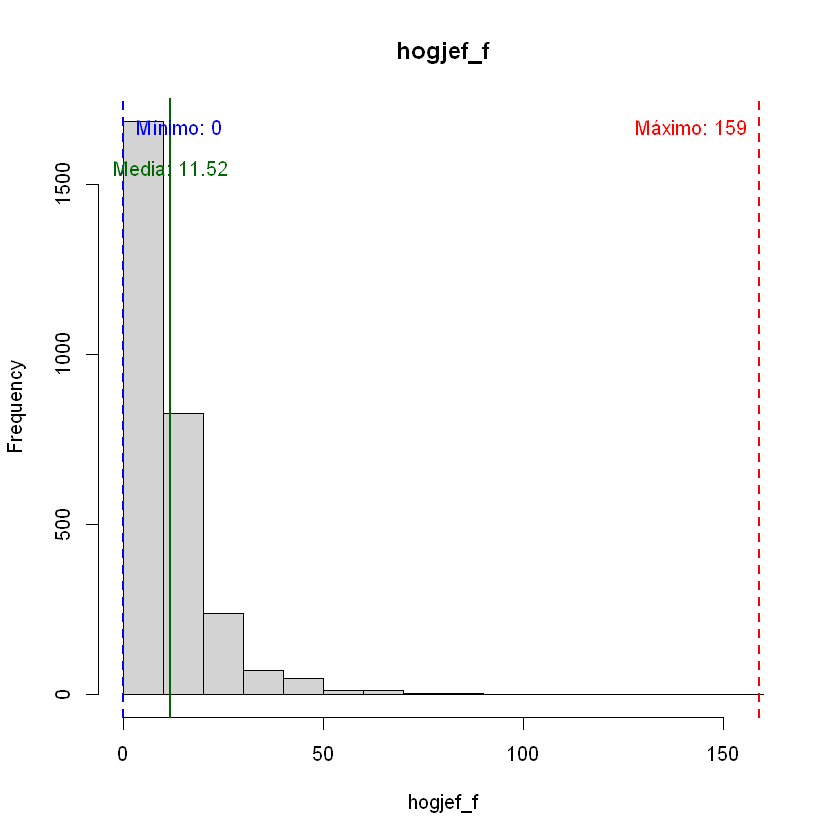

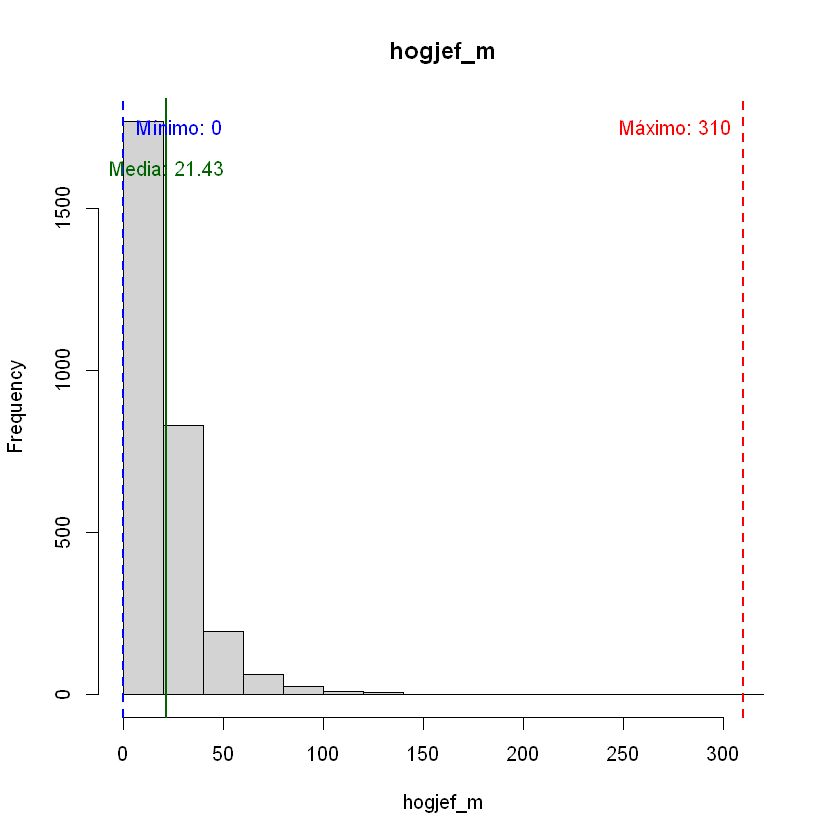

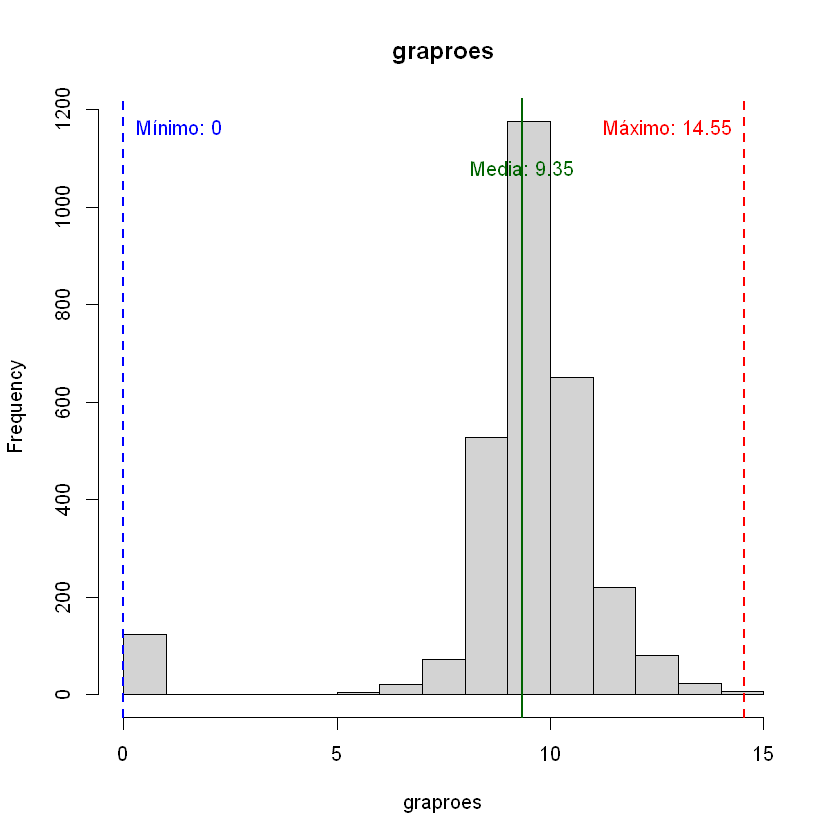

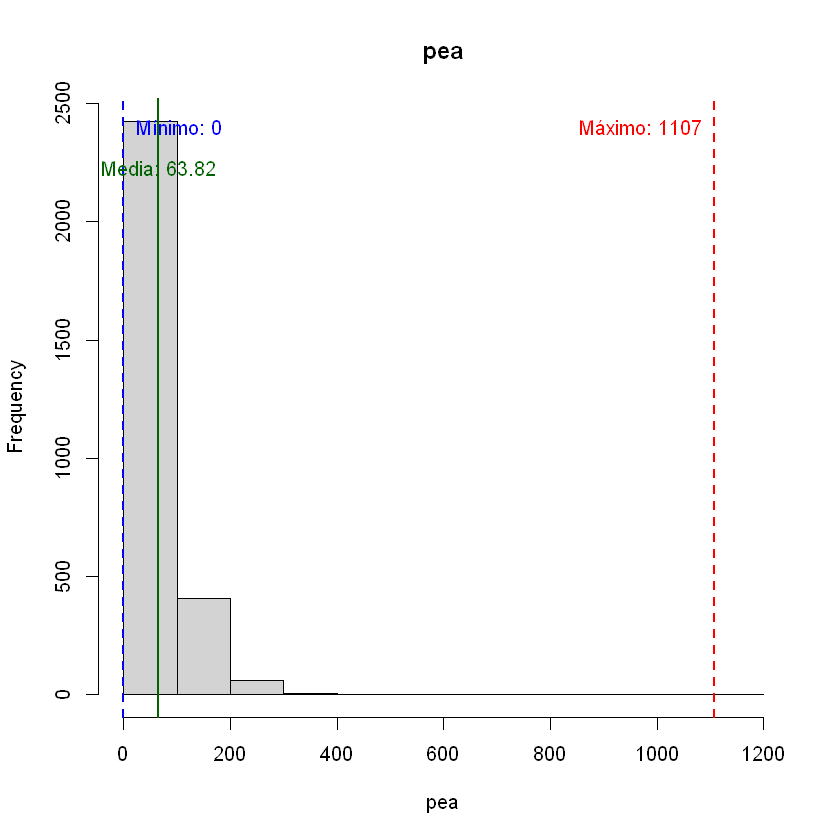

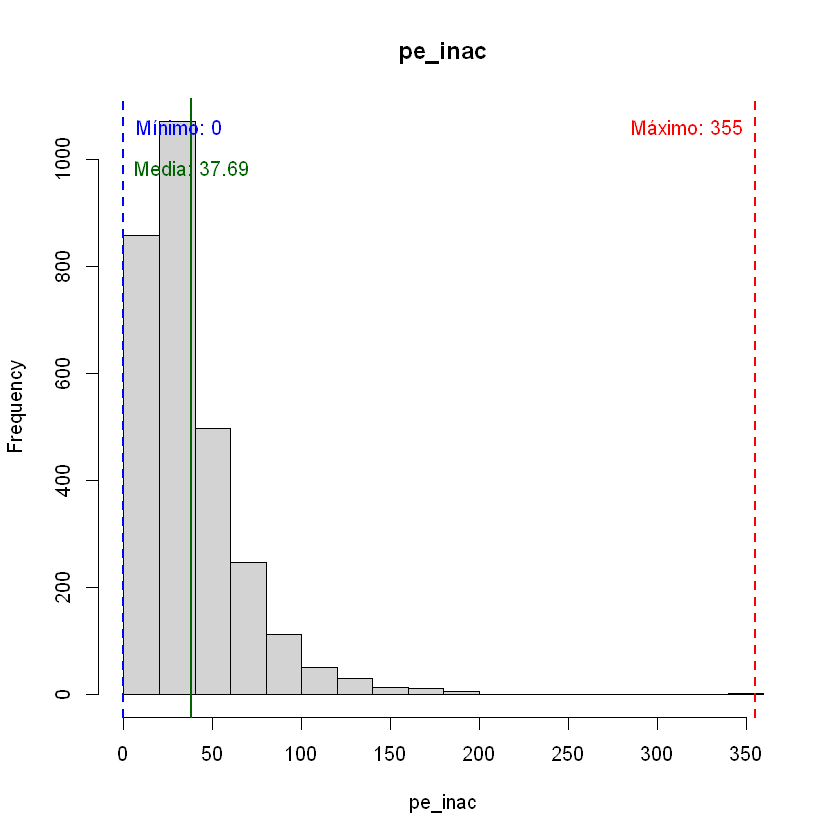

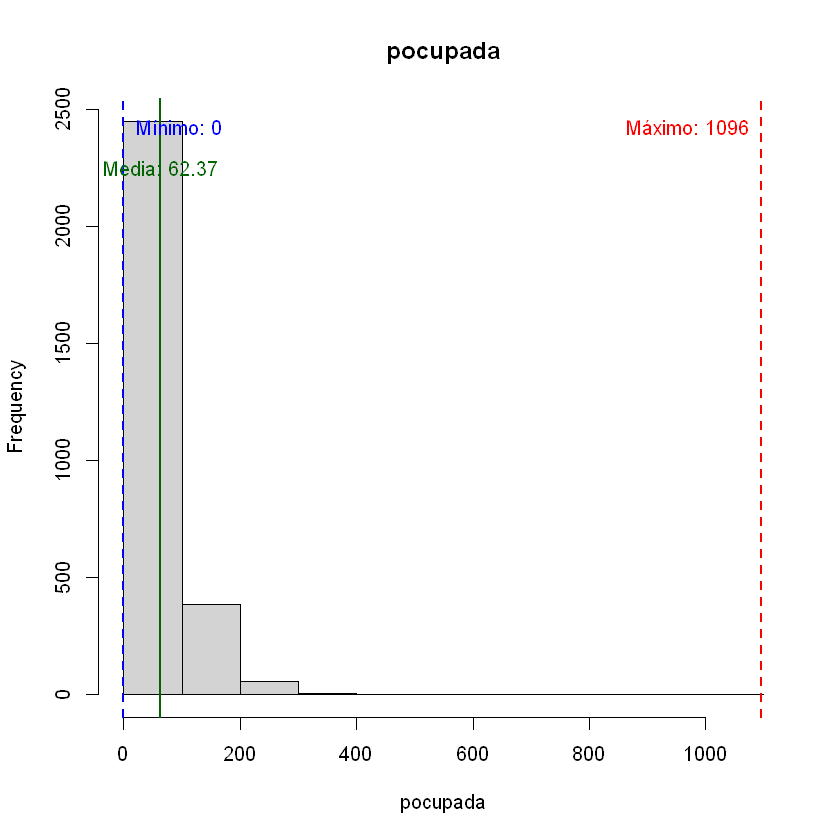

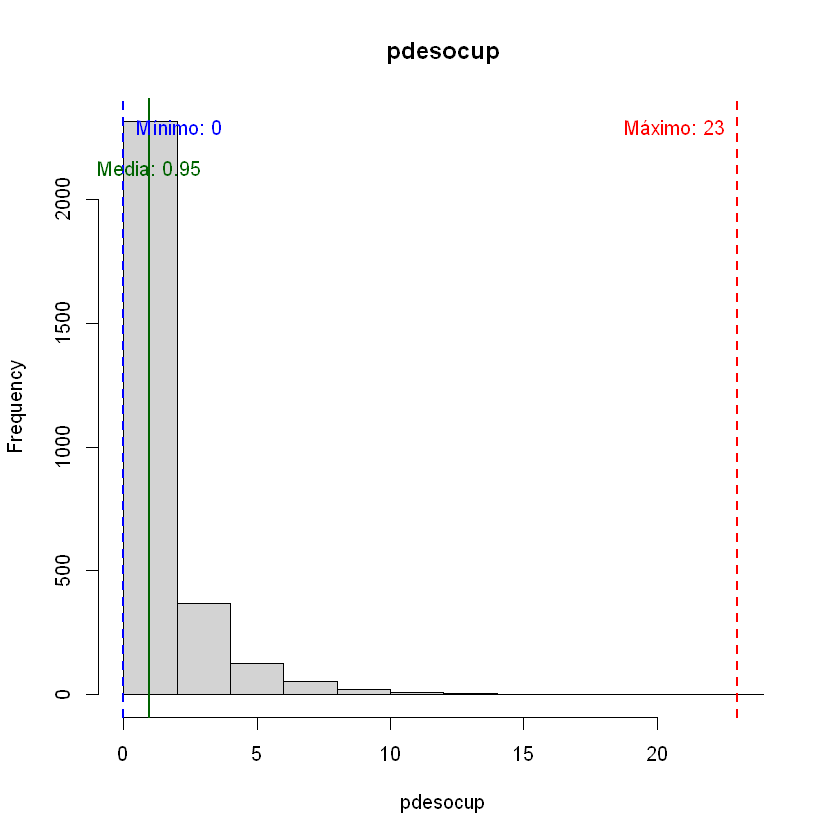

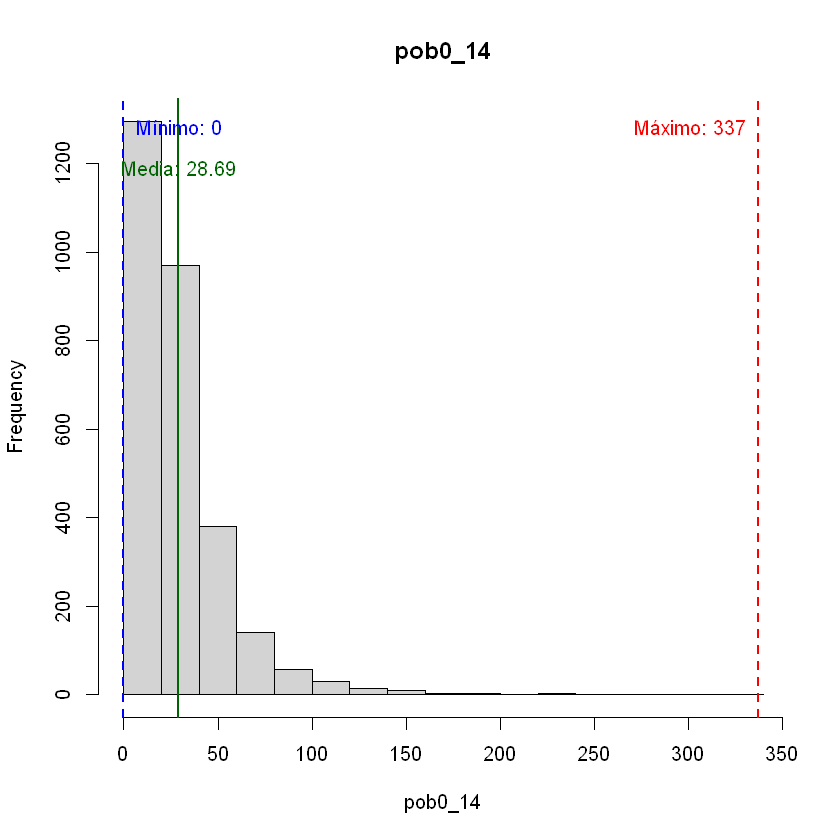

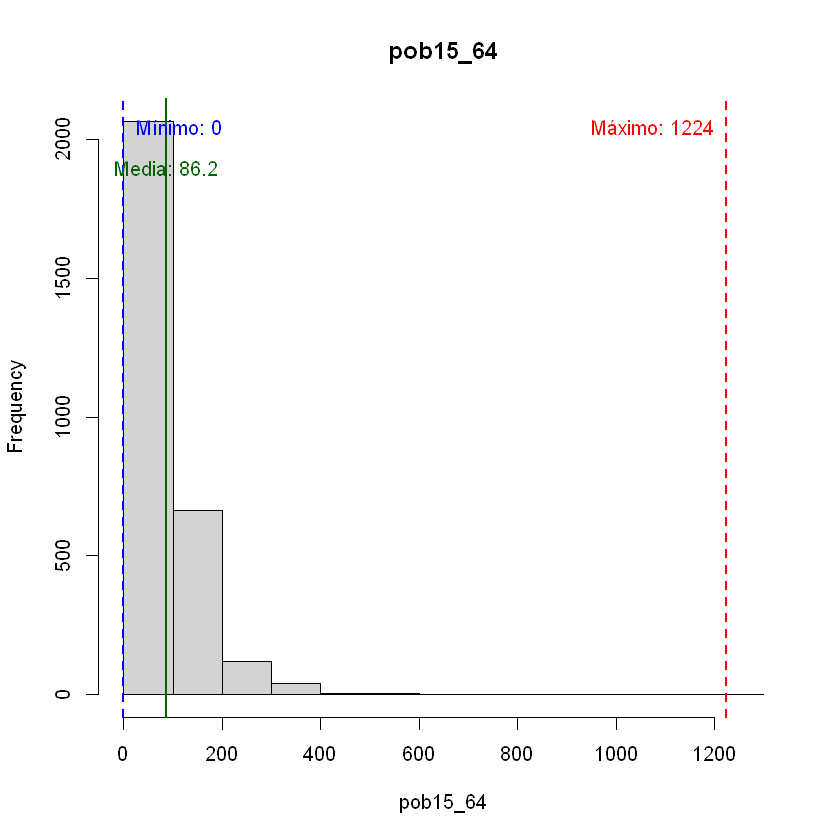

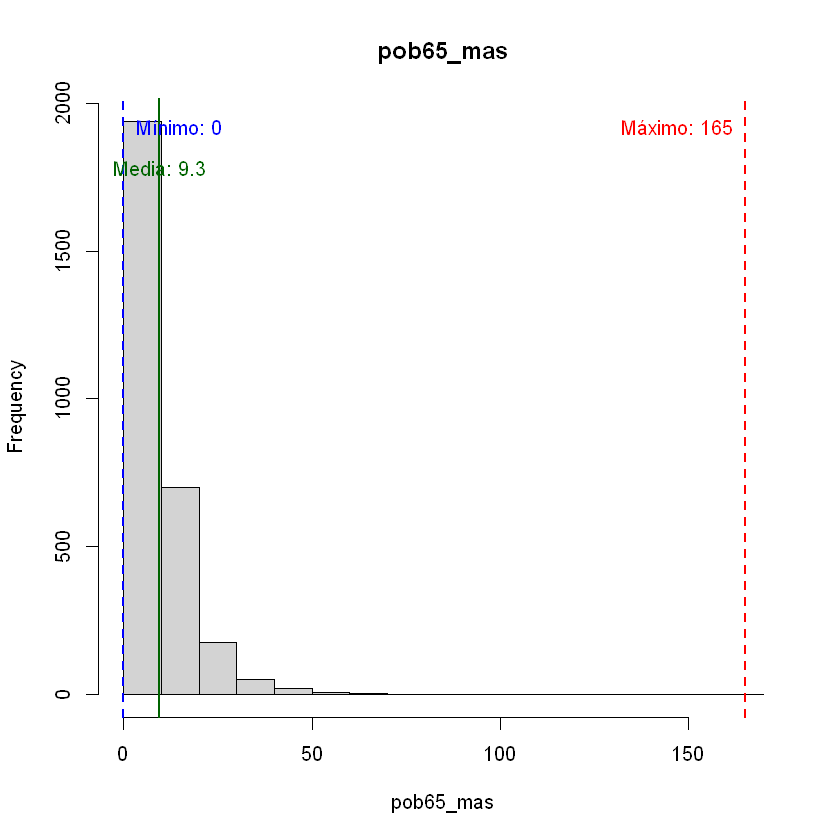

$hogjef_f
NULL

$hogjef_m
NULL

$graproes
NULL

$pea
NULL

$pe_inac
NULL

$pocupada
NULL

$pdesocup
NULL

$pob0_14
NULL

$pob15_64
NULL

$pob65_mas
NULL

$imn_2020
NULL

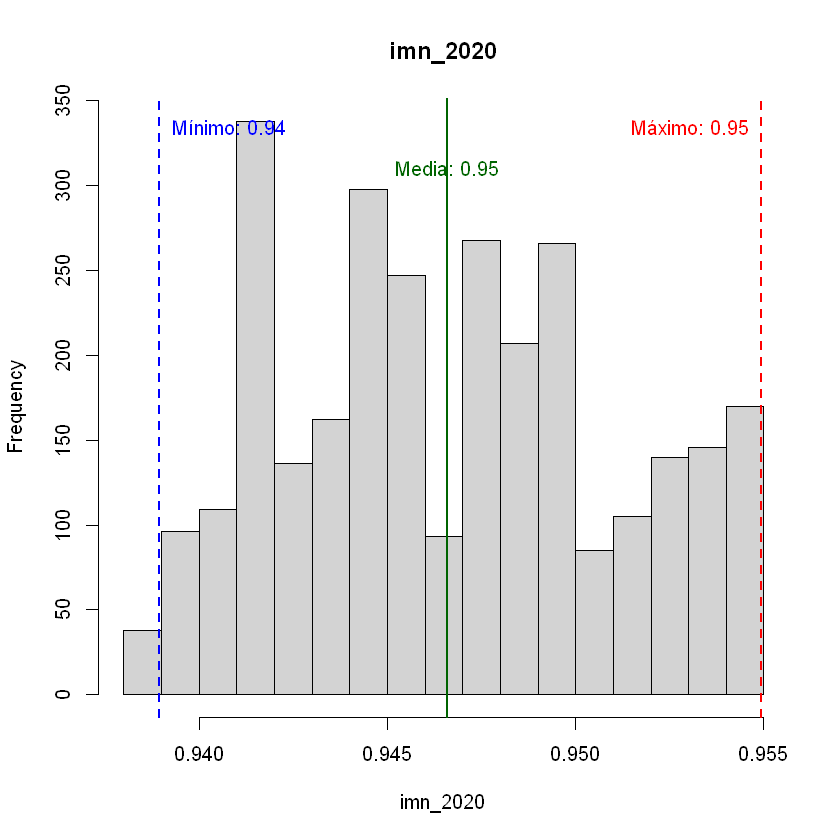

In [12]:

# Inspección de variables
datos_colonias %>%
  select(hogjef_f, hogjef_m, graproes, pea, pe_inac, pocupada, pdesocup, pob0_14, pob15_64, pob65_mas,imn_2020) %>%
  map2(names(.), ~{
    # Calcular máximos, mínimos y medias
    min_val <- min(.x, na.rm = TRUE)
    max_val <- max(.x, na.rm = TRUE)
    mean_val <- mean(.x, na.rm = TRUE)
    
    # Histograma
    hist(.x, main = .y, xlab = .y, col = "lightgray", border = "black")
    
    # Líneas de máximos, mínimos y medias
    abline(v = min_val, col = "blue", lty = 2, lwd = 2)
    abline(v = max_val, col = "red", lty = 2, lwd = 2)
    abline(v = mean_val, col = "darkgreen", lty = 1, lwd = 2)
    
    # Etiquetas
    text(min_val, par("usr")[4] * 0.95, labels = paste("Mínimo:", round(min_val, 2)), col = "blue", pos = 4)
    text(max_val, par("usr")[4] * 0.95, labels = paste("Máximo:", round(max_val, 2)), col = "red", pos = 2)
    text(mean_val, par("usr")[4] * 0.85, labels = paste("Media:", round(mean_val, 2)), col = "darkgreen", pos = 3)
  })


## Modelos
#### 3. Se establecen los modelos a utilizar

In [13]:
#Modelo general
var_modelo <- simi ~ hogjef_f + hogjef_m + graproes + pea +  
              pe_inac + pocupada + pdesocup + pob0_14 + pob15_64 + pob65_mas

#Modelo con transformación de variables de población a logaritmos. Se utiliza 1 para evitar problemas con ceros
var_modelo2 <- simi ~ log(1 + hogjef_f) + log(1 + hogjef_m) + graproes + log(1 + pea) +  
              log(1 + pe_inac) + log(1 + pocupada) + log(1 + pdesocup) + 
              log(1 + pob0_14) + log(1 + pob15_64) + log(1 + pob65_mas)

#### Modelo probit

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


=== RESULTADOS DEL MODELO PROBIT : === 

Call:
glm(formula = var_modelo, family = link_model, data = datos_colonias)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.169468   0.257440  -8.427  < 2e-16 ***
hogjef_f    -0.001087   0.017018  -0.064   0.9491    
hogjef_m     0.025554   0.014405   1.774   0.0761 .  
graproes     0.031545   0.027659   1.141   0.2541    
pea         -0.076610   0.091018  -0.842   0.4000    
pe_inac     -0.042467   0.024924  -1.704   0.0884 .  
pocupada     0.015783   0.086878   0.182   0.8558    
pdesocup    -0.113903   0.090695  -1.256   0.2092    
pob0_14      0.042366   0.010148   4.175 2.98e-05 ***
pob15_64     0.036525   0.025738   1.419   0.1559    
pob65_mas    0.029846   0.026386   1.131   0.2580    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 529.4  on 2903  degrees of freedom
Residual deviance: 488.1  on 2893  degre

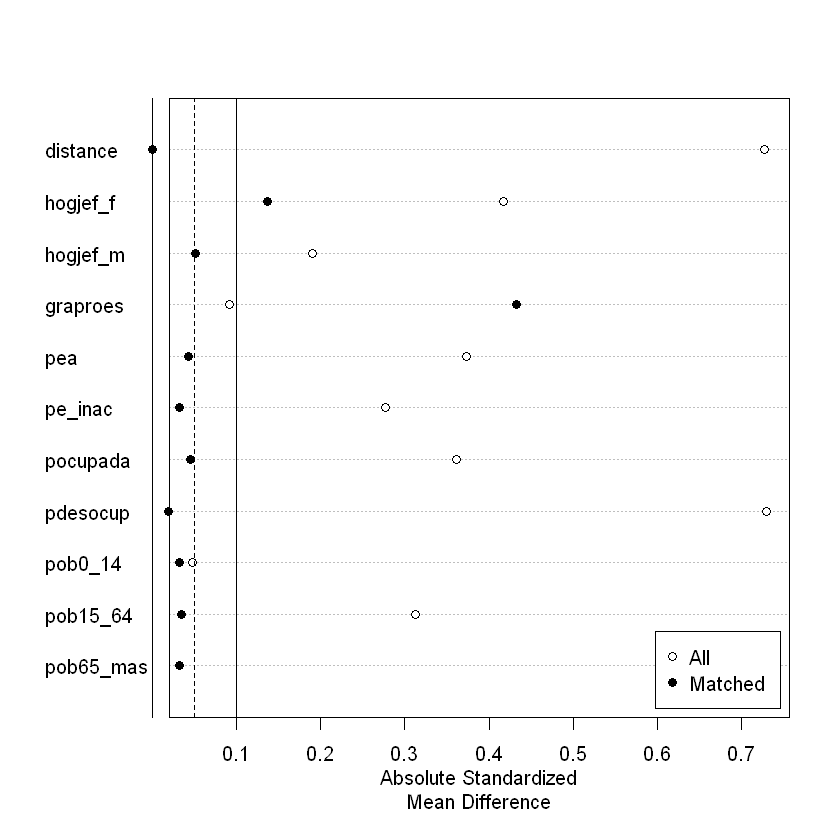

In [14]:
propscorematch(var_modelo = var_modelo, link_model = binomial(link = "probit"), t_test_var = "imn_2020")

#### Modelo probit con transformación de variables de población a logaritmos

=== RESULTADOS DEL MODELO PROBIT : === 

Call:
glm(formula = var_modelo, family = link_model, data = datos_colonias)

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -2.27992    0.30168  -7.557 4.11e-14 ***
log(1 + hogjef_f)  -0.20955    0.10994  -1.906  0.05665 .  
log(1 + hogjef_m)   0.27559    0.24826   1.110  0.26695    
graproes           -0.03045    0.04896  -0.622  0.53393    
log(1 + pea)       -5.15876    3.10476  -1.662  0.09660 .  
log(1 + pe_inac)   -0.72954    0.25268  -2.887  0.00389 ** 
log(1 + pocupada)   2.96975    2.95092   1.006  0.31423    
log(1 + pdesocup)  -0.20244    0.14956  -1.354  0.17588    
log(1 + pob0_14)    0.52440    0.21331   2.458  0.01395 *  
log(1 + pob15_64)   2.23972    0.77128   2.904  0.00369 ** 
log(1 + pob65_mas)  0.07919    0.09375   0.845  0.39832    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 529

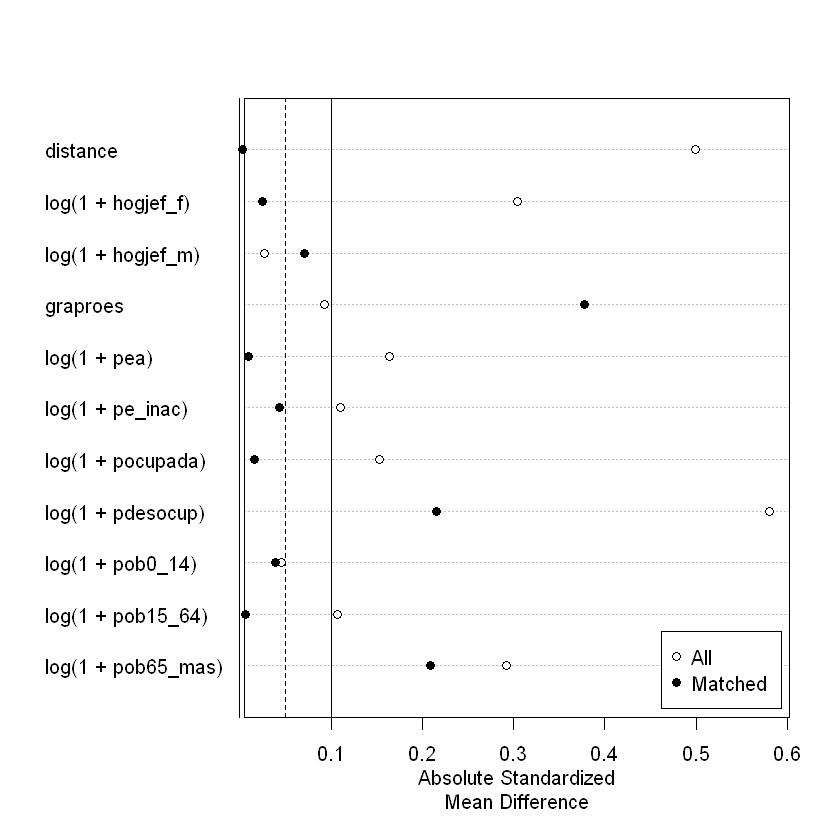

In [15]:
propscorematch(var_modelo = var_modelo2, link_model = binomial(link = "probit"), t_test_var = "imn_2020")

#### Modelo logit   

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


=== RESULTADOS DEL MODELO LOGIT : === 

Call:
glm(formula = var_modelo, family = link_model, data = datos_colonias)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.104618   0.631493  -6.500 8.04e-11 ***
hogjef_f    -0.000985   0.041689  -0.024   0.9811    
hogjef_m     0.057572   0.033809   1.703   0.0886 .  
graproes     0.072038   0.067621   1.065   0.2867    
pea         -0.193690   0.218278  -0.887   0.3749    
pe_inac     -0.109612   0.059647  -1.838   0.0661 .  
pocupada     0.040800   0.208319   0.196   0.8447    
pdesocup    -0.277124   0.224704  -1.233   0.2175    
pob0_14      0.097968   0.023327   4.200 2.67e-05 ***
pob15_64     0.097028   0.061757   1.571   0.1162    
pob65_mas    0.075359   0.063004   1.196   0.2317    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 529.40  on 2903  degrees of freedom
Residual deviance: 489.35  on 2893  degr

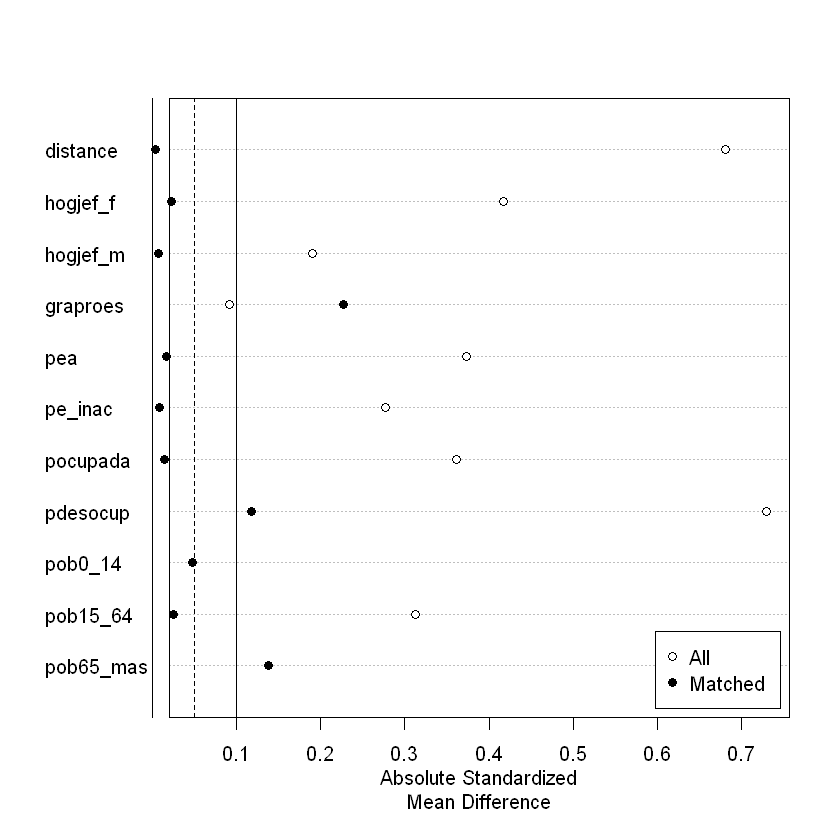

In [16]:
propscorematch(var_modelo = var_modelo, link_model = binomial(link = "logit"), t_test_var = "imn_2020")

#### Modelo logit con transformación de variables de población a logaritmos


=== RESULTADOS DEL MODELO LOGIT : === 

Call:
glm(formula = var_modelo, family = link_model, data = datos_colonias)

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -4.35386    0.75117  -5.796 6.79e-09 ***
log(1 + hogjef_f)   -0.47048    0.25467  -1.847  0.06469 .  
log(1 + hogjef_m)    0.71580    0.62434   1.146  0.25160    
graproes            -0.06455    0.11889  -0.543  0.58714    
log(1 + pea)       -11.89294    7.42140  -1.603  0.10904    
log(1 + pe_inac)    -1.43321    0.55404  -2.587  0.00969 ** 
log(1 + pocupada)    7.05390    7.06862   0.998  0.31832    
log(1 + pdesocup)   -0.52709    0.38825  -1.358  0.17459    
log(1 + pob0_14)     1.26000    0.52298   2.409  0.01598 *  
log(1 + pob15_64)    4.65708    1.75162   2.659  0.00784 ** 
log(1 + pob65_mas)   0.14373    0.21971   0.654  0.51300    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null de

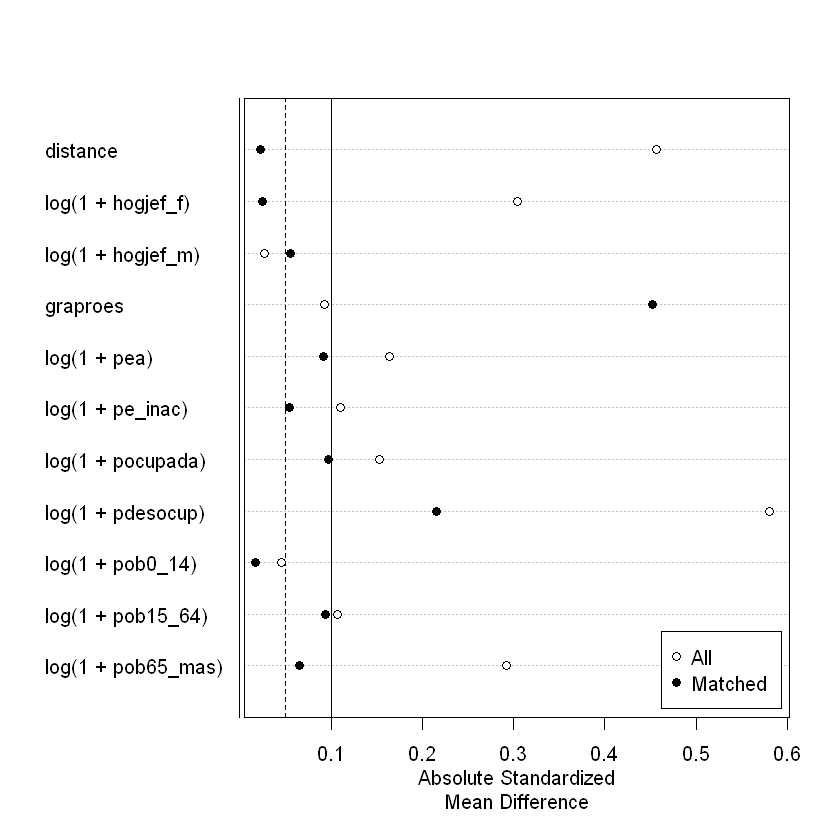

In [17]:
propscorematch(var_modelo = var_modelo2, link_model = binomial(link = "logit"), t_test_var = "imn_2020")

#### Modelo probit con variable de interés "pct_sinesc" Porcentaje de población sin escolaridad

In [18]:
#Modelo con menos variables
var_modelo3<-simi ~ log(1+hogjef_f) + log(1+pe_inac)+log(1+pdesocup) +log(1+pob0_14)+log(1+pob65_mas)

=== RESULTADOS DEL MODELO PROBIT : === 

Call:
glm(formula = var_modelo, family = link_model, data = datos_colonias)

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -2.34223    0.22988 -10.189  < 2e-16 ***
log(1 + hogjef_f)  -0.28734    0.09197  -3.124  0.00178 ** 
log(1 + pe_inac)   -0.08341    0.14916  -0.559  0.57604    
log(1 + pdesocup)  -0.27324    0.12451  -2.195  0.02819 *  
log(1 + pob0_14)    0.40965    0.14678   2.791  0.00526 ** 
log(1 + pob65_mas) -0.04348    0.07741  -0.562  0.57435    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 529.40  on 2903  degrees of freedom
Residual deviance: 505.46  on 2898  degrees of freedom
AIC: 517.46

Number of Fisher Scoring iterations: 7

=== RESUMEN DE LOS RESULTADOS DE MATCHIT: === 

Call:
matchit(formula = var_modelo, data = datos_colonias, method = "nearest", 
    distance = prs_df$pr_score)

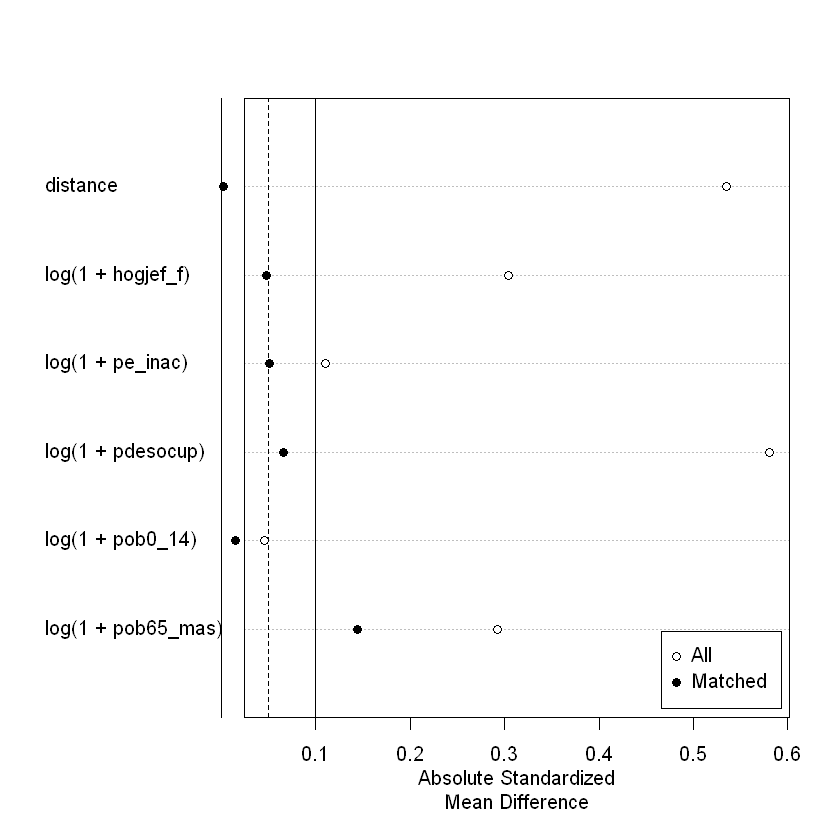

In [19]:
propscorematch(var_modelo = var_modelo3, link_model = binomial(link = "probit"), t_test_var = "pct_sinesc")

#### Modelo probit con variable de interés "imn_2020" Índice de marginación


=== RESULTADOS DEL MODELO PROBIT : === 

Call:
glm(formula = var_modelo, family = link_model, data = datos_colonias)

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -2.34223    0.22988 -10.189  < 2e-16 ***
log(1 + hogjef_f)  -0.28734    0.09197  -3.124  0.00178 ** 
log(1 + pe_inac)   -0.08341    0.14916  -0.559  0.57604    
log(1 + pdesocup)  -0.27324    0.12451  -2.195  0.02819 *  
log(1 + pob0_14)    0.40965    0.14678   2.791  0.00526 ** 
log(1 + pob65_mas) -0.04348    0.07741  -0.562  0.57435    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 529.40  on 2903  degrees of freedom
Residual deviance: 505.46  on 2898  degrees of freedom
AIC: 517.46

Number of Fisher Scoring iterations: 7

=== RESUMEN DE LOS RESULTADOS DE MATCHIT: === 

Call:
matchit(formula = var_modelo, data = datos_colonias, method = "nearest", 
    distance = prs_df$pr_score)

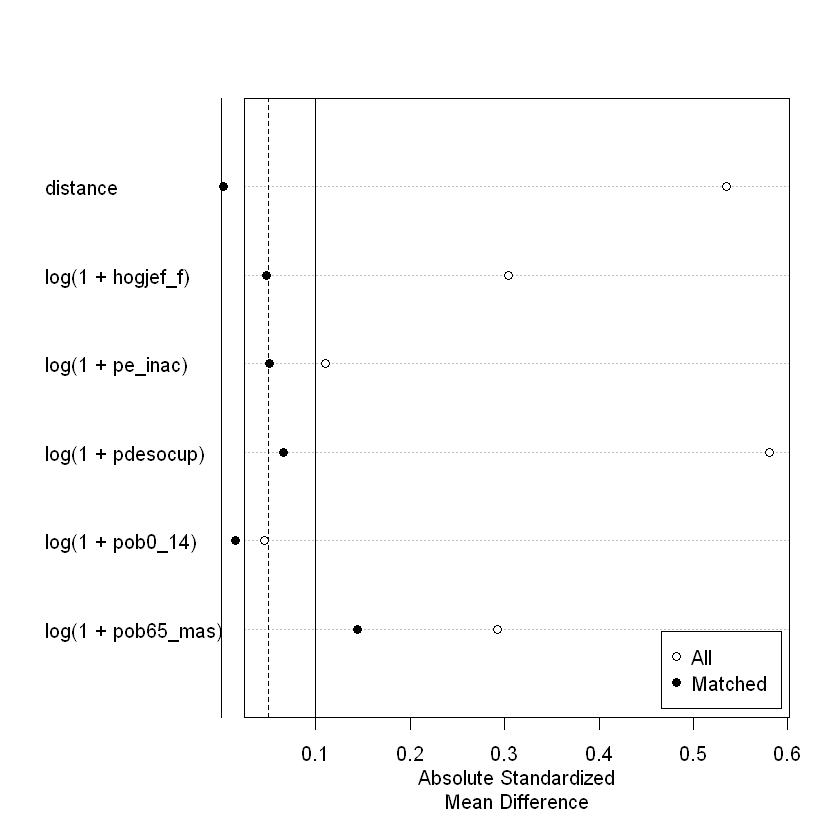

In [20]:
propscorematch(var_modelo = var_modelo3, link_model = binomial(link = "probit"), t_test_var = "imn_2020")

#### Modelo logit con variable de interés "pct_sinder" Porcentaje de población sin derechohabiencia

=== RESULTADOS DEL MODELO LOGIT : === 

Call:
glm(formula = var_modelo, family = link_model, data = datos_colonias)

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -4.6473     0.5892  -7.888 3.07e-15 ***
log(1 + hogjef_f)   -0.6738     0.2082  -3.237  0.00121 ** 
log(1 + pe_inac)    -0.1507     0.3560  -0.423  0.67195    
log(1 + pdesocup)   -0.7099     0.3412  -2.081  0.03747 *  
log(1 + pob0_14)     0.9373     0.3533   2.653  0.00797 ** 
log(1 + pob65_mas)  -0.1073     0.1844  -0.582  0.56062    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 529.40  on 2903  degrees of freedom
Residual deviance: 505.97  on 2898  degrees of freedom
AIC: 517.97

Number of Fisher Scoring iterations: 7

=== RESUMEN DE LOS RESULTADOS DE MATCHIT: === 

Call:
matchit(formula = var_modelo, data = datos_colonias, method = "nearest", 
    distance = prs_df$pr_score)


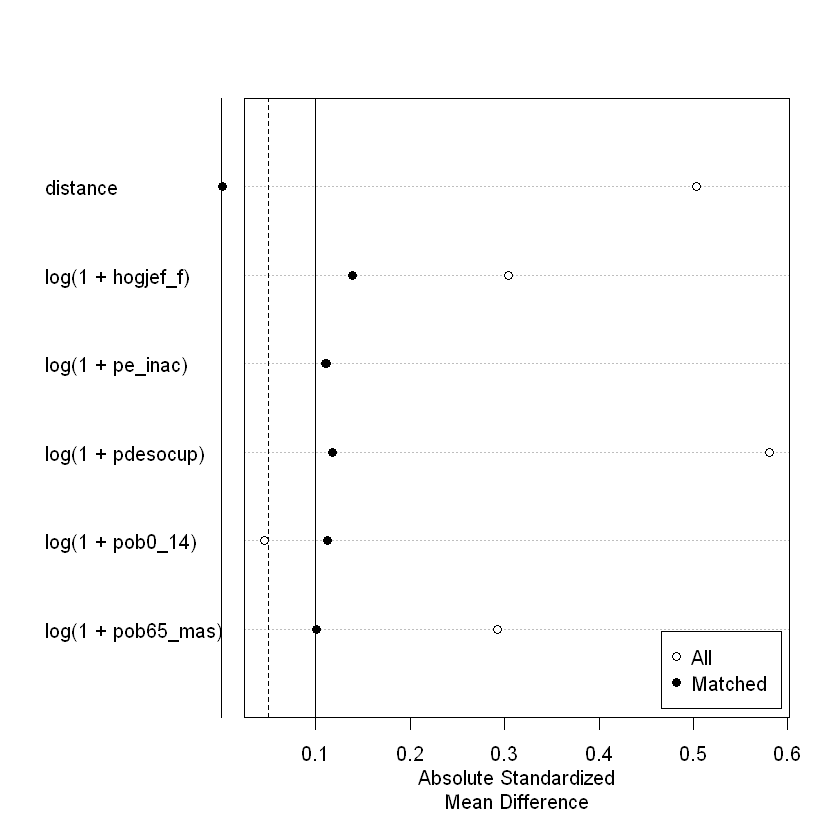

In [21]:
propscorematch(var_modelo = var_modelo3, link_model = binomial(link = "logit"), t_test_var = "pct_sinder")